# Prediction Model

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_pickle('./tmp/df_cleaned.gzip')


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600 entries, 6 to 6715
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BuildingType            5600 non-null   object 
 1   PrimaryPropertyType     5600 non-null   object 
 2   Neighborhood            5600 non-null   object 
 3   NumberofFloors          5370 non-null   float64
 4   PropertyGFATotal        5258 non-null   float64
 5   LargestPropertyUseType  5482 non-null   object 
 6   ENERGYSTARScore         4292 non-null   float64
 7   SourceEUI(kBtu/sf)      5281 non-null   float64
 8   SiteEnergyUse(kBtu)     5400 non-null   float64
 9   TotalGHGEmissions       5600 non-null   float64
 10  GHGEmissionsIntensity   5335 non-null   float64
 11  BuildingAge             5600 non-null   int64  
 12  Distance                5600 non-null   float64
 13  NaturalGasRate          5160 non-null   float64
dtypes: float64(9), int64(1), object(4)
memor

In [4]:
# on regarde simplement quelles sont les formes des features
feats = pd.DataFrame(
    columns=['feature', 'std', 'skew', 'var', 'kur']
)
agg_func = ['std', 'skew', 'var', 'kurtosis']

for f in df.select_dtypes(['float', 'int']):
    res = df[f].agg(agg_func)
    feats = feats.append(
        {'feature': f, 'std': res[0], 'skew': res[1],
            'var': res[2], 'kur': res[3]},
        ignore_index=True)

feats


,feature,std,skew,var,kur
0,NumberofFloors,1.767021e+00,0.445056,3.122362e+00,-0.237538
1,PropertyGFATotal,3.375187e+04,1.613754,1.139189e+09,2.095403
2,ENERGYSTARScore,2.625680e+01,-0.900268,6.894196e+02,-0.106955
3,SourceEUI(kBtu/sf),4.438234e+01,0.968131,1.969793e+03,0.961476
4,SiteEnergyUse(kBtu),1.777724e+06,1.598250,3.160301e+12,2.186972
5,TotalGHGEmissions,4.800313e+01,1.468106,2.304301e+03,1.507648
6,GHGEmissionsIntensity,6.821282e-01,1.468306,4.652989e-01,1.486484
7,BuildingAge,3.326957e+01,0.523466,1.106864e+03,-0.929233
8,Distance,2.219051e+00,0.803548,4.924188e+00,-0.286699
9,NaturalGasRate,2.683825e-01,0.754646,7.202919e-02,-0.637035


## Predition Function

In [5]:

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from datetime import datetime


prediction = 'TotalGHGEmissions'
removed_features = 'ENERGYSTARScore'

X = df.drop([prediction, removed_features], axis=1)
y = df[prediction]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)


def runModel(
    model, 
    params={},
    pre_processing_steps = [
                ("imputer", SimpleImputer()),
                ("scaler", StandardScaler(with_mean=False))
            ]
    ):
    start_time = datetime.now()
    # categorical features : they are only nominal (not cardinal),
    # thus we could encode them with OneHotEncoder (not OrdinalEncoder)
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")


    numeric_transformer = Pipeline(
        steps = pre_processing_steps
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, selector(dtype_exclude="object")),
            ("cat", categorical_transformer, selector(dtype_include="object"))
        ]
    )

    reg = Pipeline(
        steps=[("preprocessor", preprocessor), ("regressor", model)]
    )

    reg.fit(X_train, y_train)

    # by default, add a parameter for imputer, for all model's grid search
    # params["preprocessor__num__imputer__strategy"] = ["mean", "median"]

    gs = GridSearchCV(
        estimator=reg,
        cv=5,
        param_grid=params,
        scoring=('r2', 'neg_mean_absolute_error'),
        refit='r2',
        return_train_score=True,
        n_jobs=-1
    )

    gs.fit(X_train, y_train)
    end_time = datetime.now()

    ellapsed_time = (end_time - start_time).total_seconds()
    y_pred = gs.predict(X_test)

    ret = {
        'model': type(model).__name__,
        'compute_time': ellapsed_time,
        'best_params': gs.best_params_,
        'RMSE': np.sqrt(mean_squared_error(y_pred, y_test)),
        'MAE': mean_absolute_error(y_pred, y_test),
        'R2': r2_score(y_pred, y_test),
        'cv_results': gs.cv_results_,
        'model_train_score': gs.score(X_train, y_train),
        'model_test_score': gs.score(X_test, y_test)
    }

    # TODO print validation curve : https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py

    return ret


In [6]:

# Dummy regressor as for testing
runModel(DummyRegressor(strategy="mean"));


## Preprocessing Optimization

We use a simple Linear Regression to assess what are the best pre processing steps to consider: which ones optimizes our results

In [7]:
# Regressor as a baseline

# res_baseline = pd.DataFrame(
#     columns=['testcase', 'model', 'compute_time', 'best_params', 'RMSE', 'MAE',
#              'R2', 'cv_results', 'model_train_score', 'model_test_score']
# )

def best_preprocessing_params():
    parameters = {
        # "preprocessor__num__imputer__strategy" : ["mean", "median"]
        "preprocessor__num__imputer__strategy" : ["mean"]
    }

    model = LinearRegression()

    ret0 = runModel(model, parameters)
    ret0['testcase'] = 'No preprocessing'

    ret1 = runModel(model, parameters, [("imputer", SimpleImputer())])
    ret1['testcase'] = 'SimpleImputer only'

    ret2 = runModel(model, parameters, [("imputer", SimpleImputer()), ("minmax", MinMaxScaler())])
    ret2['testcase'] = 'SimpleImputer + MinMax'

    ret3 = runModel(model, parameters, [("imputer", SimpleImputer()), ("minmax", MinMaxScaler()), ("scaler", StandardScaler(with_mean=False))])
    ret3['testcase'] = 'SimpleImputer + Minmax + StdScaler'

    ret4 = runModel(model, parameters, [("imputer", SimpleImputer()), ("scaler", StandardScaler(with_mean=False))])
    ret4['testcase'] = 'SimpleImputer + StdScaler'

    ret5 = runModel(model, parameters, [("imputer", SimpleImputer()), ("scaler", StandardScaler())])
    ret5['testcase'] = 'SimpleImputer + StdScaler(w/ mean)'

    res_baseline = pd.DataFrame.from_dict([ret1, ret2, ret3, ret4, ret5])

    # res_baseline = res_baseline.append(ret1, ignore_index=True)
    # res_baseline = res_baseline.append(ret2, ignore_index=True)
    # res_baseline = res_baseline.append(ret3, ignore_index=True)
    # res_baseline = res_baseline.append(ret4, ignore_index=True)
    # res_baseline = res_baseline.append(ret5, ignore_index=True)

    # res_baseline.T
    res_baseline_draw = res_baseline.set_index('testcase')
    # Clear dataframe for successive runs
    # res_baseline.drop(res_baseline.index, inplace=True)
    return res_baseline_draw


# need to compute several times, since we have side effects on memory allocation on jupyter notebooks at firsts launches, which produces biased / false results for compute time (difference is very small)
res_baseline_draw = best_preprocessing_params()
for i in range(5):
    res_baseline_draw = res_baseline_draw.append(best_preprocessing_params())
    # res_baseline_draw = best_preprocessing_params()

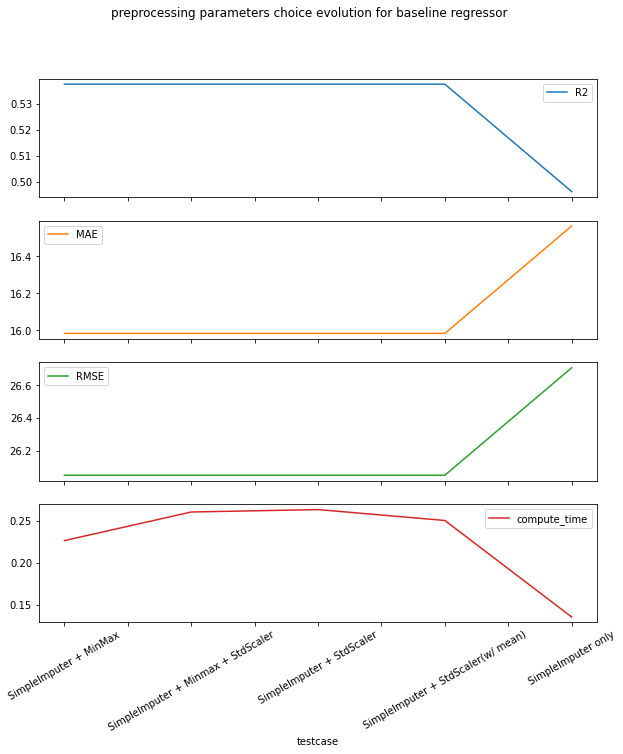

In [8]:
res_baseline_draw[['R2', 'MAE', 'RMSE', 'compute_time']].groupby(level=0).mean().plot(rot=30, kind='line',  subplots=True, figsize=(10, 10), 
    title='preprocessing parameters choice evolution for baseline regressor');

SimpleImputer is mandatory, otherwise we have errors of missing values for training the model

Then, in order to reduce the error & raise the score, we have to choose at least a StandardScaler or a MinMax (both at the same time are not providing a significant improvement, with a slight increase in compute time)

> We choose to keep SimpleImputer + StdScaler (w/mean), which provides a slightly shorter compute time, for the same benefit

## Models compute

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as xgb
from xgboost import XGBRegressor
import os
from dataclasses import dataclass
from datetime import datetime

xgb.set_config(verbosity=0)


@dataclass
class ModelCompute:
    model: object
    params: dict



In [12]:

hyper_params_baseline = dict()

hyper_params_baseline['parameters_svr'] = {
    # 'regressor__C': np.logspace(-2, -1, 10),
    # 'regressor__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

hyper_params_baseline['parameters_rf'] = {
    # 'regressor__n_estimators': [10, 50, 100, 300, 500],
    # 'regressor__min_samples_leaf': [1, 3, 5, 10],
    # 'regressor__max_features': ['auto', 'sqrt', 'log2'],

    # 'regressor__max_depth' : [5, 15, 25, 50],
    # 'regressor__min_samples_split': [2, 5, 10],
    # 'regressor__bootstrap' : [True, False],
}

hyper_params_baseline['parameters_knn'] = {
    # 'regressor__n_neighbors': [2, 4, 8, 10, 16]
}

hyper_params_baseline['parameters_xgb'] = {
    'regressor__n_estimators': [10],
    # 'regressor__n_estimators': [200, 500, 1000],
    # 'regressor__max_depth': [2, 5, 10],
    # 'regressor__eval_metric': ["rmse"],
}

hyper_params_baseline['parameters_ridge'] = {
    # 'regressor__alpha': np.logspace(-5, 5, 100)
}

hyper_params_baseline['parameters_lasso'] = {
    # 'regressor__alpha': np.logspace(-5, 5, 50)
}

hyper_params_baseline['parameters_net'] = {
    # 'regressor__alpha': np.logspace(-5, 5, 50),
    # 'regressor__l1_ratio' : np.logspace(-5, 5, 200),
}

hyper_params = hyper_params_baseline

models = [
    # ModelCompute(DummyRegressor(strategy="mean"), {}),
    ModelCompute(LinearRegression(n_jobs=os.cpu_count()), {}),
    ModelCompute(KNeighborsRegressor(), hyper_params['parameters_knn']),
    ModelCompute(RandomForestRegressor(n_jobs=os.cpu_count()), hyper_params['parameters_rf']),
    ModelCompute(XGBRegressor(n_jobs=os.cpu_count()), hyper_params['parameters_xgb']),
    ModelCompute(LinearSVR(), hyper_params['parameters_svr']),
    ModelCompute(Ridge(), hyper_params['parameters_ridge']),
    ModelCompute(Lasso(tol=1000), hyper_params['parameters_lasso']),
    ModelCompute(ElasticNet(tol=1000), hyper_params['parameters_net'])
]

results = pd.DataFrame(
    columns=['model', 'compute_time', 'best_params', 'RMSE', 'MAE',
             'R2', 'cv_results', 'model_train_score', 'model_test_score']
)

print(f'computing models with {os.cpu_count()} cpus')

start_time = datetime.now()
for mod in models:
    print(f'computing model {type(mod.model).__name__}...', end='')
    ret = runModel(mod.model, mod.params)
    results = results.append(ret, ignore_index=True)
    print('done.')
print(f'finished compute models in {datetime.now() - start_time}')

results.T



computing models with 32 cpus
computing model LinearRegression...done.
computing model KNeighborsRegressor...done.
computing model RandomForestRegressor...done.
computing model XGBRegressor...done.
computing model LinearSVR...done.
computing model Ridge...done.
computing model Lasso...done.
computing model ElasticNet...done.
finished compute models in 0:00:28.550228


,0,1,2,3,4,5,6,7
model,LinearRegression,KNeighborsRegressor,RandomForestRegressor,XGBRegressor,LinearSVR,Ridge,Lasso,ElasticNet
compute_time,0.496062,1.175935,2.738651,21.650516,0.345438,0.359966,0.087066,0.081074
best_params,{},{},{},{'regressor__n_estimators': 10},{},{},{},{}
RMSE,26.050274,20.488999,11.12813,11.859258,27.217094,26.094162,31.353519,29.614459
MAE,15.984306,11.03397,3.467604,4.929414,14.56798,15.998995,21.15121,18.436023
R2,0.537491,0.7486,0.93746,0.921933,0.411138,0.532637,0.472718,0.240437
cv_results,"{'mean_fit_time': [0.04918923377990723], 'std_...","{'mean_fit_time': [0.011860799789428712], 'std...","{'mean_fit_time': [1.2929824829101562], 'std_f...","{'mean_fit_time': [20.084493017196657], 'std_f...","{'mean_fit_time': [0.01727743148803711], 'std_...","{'mean_fit_time': [0.020319700241088867], 'std...","{'mean_fit_time': [0.016307735443115236], 'std...","{'mean_fit_time': [0.014699745178222656], 'std..."
model_train_score,0.681207,0.873272,0.993281,0.966735,0.638695,0.679671,0.555365,0.594388
model_test_score,0.678109,0.800875,0.941261,0.933289,0.648627,0.677023,0.533709,0.584001


In [10]:
results


,model,compute_time,best_params,RMSE,MAE,R2,cv_results,model_train_score,model_test_score
0,LinearRegression,0.223989,{},26.050274,15.984306,0.537491,"{'mean_fit_time': [0.06480321884155274], 'std_...",0.681207,0.678109
1,KNeighborsRegressor,0.843853,{},20.488999,11.033970,0.748600,"{'mean_fit_time': [0.01722097396850586], 'std_...",0.873272,0.800875
2,RandomForestRegressor,2.559828,{},10.815763,3.439159,0.940803,"{'mean_fit_time': [1.3919110774993897], 'std_f...",0.993285,0.944512
3,XGBRegressor,22.470681,{'regressor__n_estimators': 10},11.859258,4.929414,0.921933,"{'mean_fit_time': [19.668487548828125], 'std_f...",0.966735,0.933289
4,LinearSVR,0.099086,{},27.228226,14.570363,0.410195,"{'mean_fit_time': [0.02076883316040039], 'std_...",0.638464,0.648340
5,Ridge,0.099230,{},26.094162,15.998995,0.532637,"{'mean_fit_time': [0.02194209098815918], 'std_...",0.679671,0.677023
6,Lasso,0.080025,{},31.353519,21.151210,0.472718,"{'mean_fit_time': [0.016873693466186522], 'std...",0.555365,0.533709
7,ElasticNet,0.063481,{},29.614459,18.436023,0.240437,"{'mean_fit_time': [0.01248946189880371], 'std_...",0.594388,0.584001


In [11]:
results.to_pickle('tmp/results.gzip')


## Models Comparison

In [7]:
results = pd.read_pickle('tmp/results.gzip')


In [8]:
result = results.set_index('model')


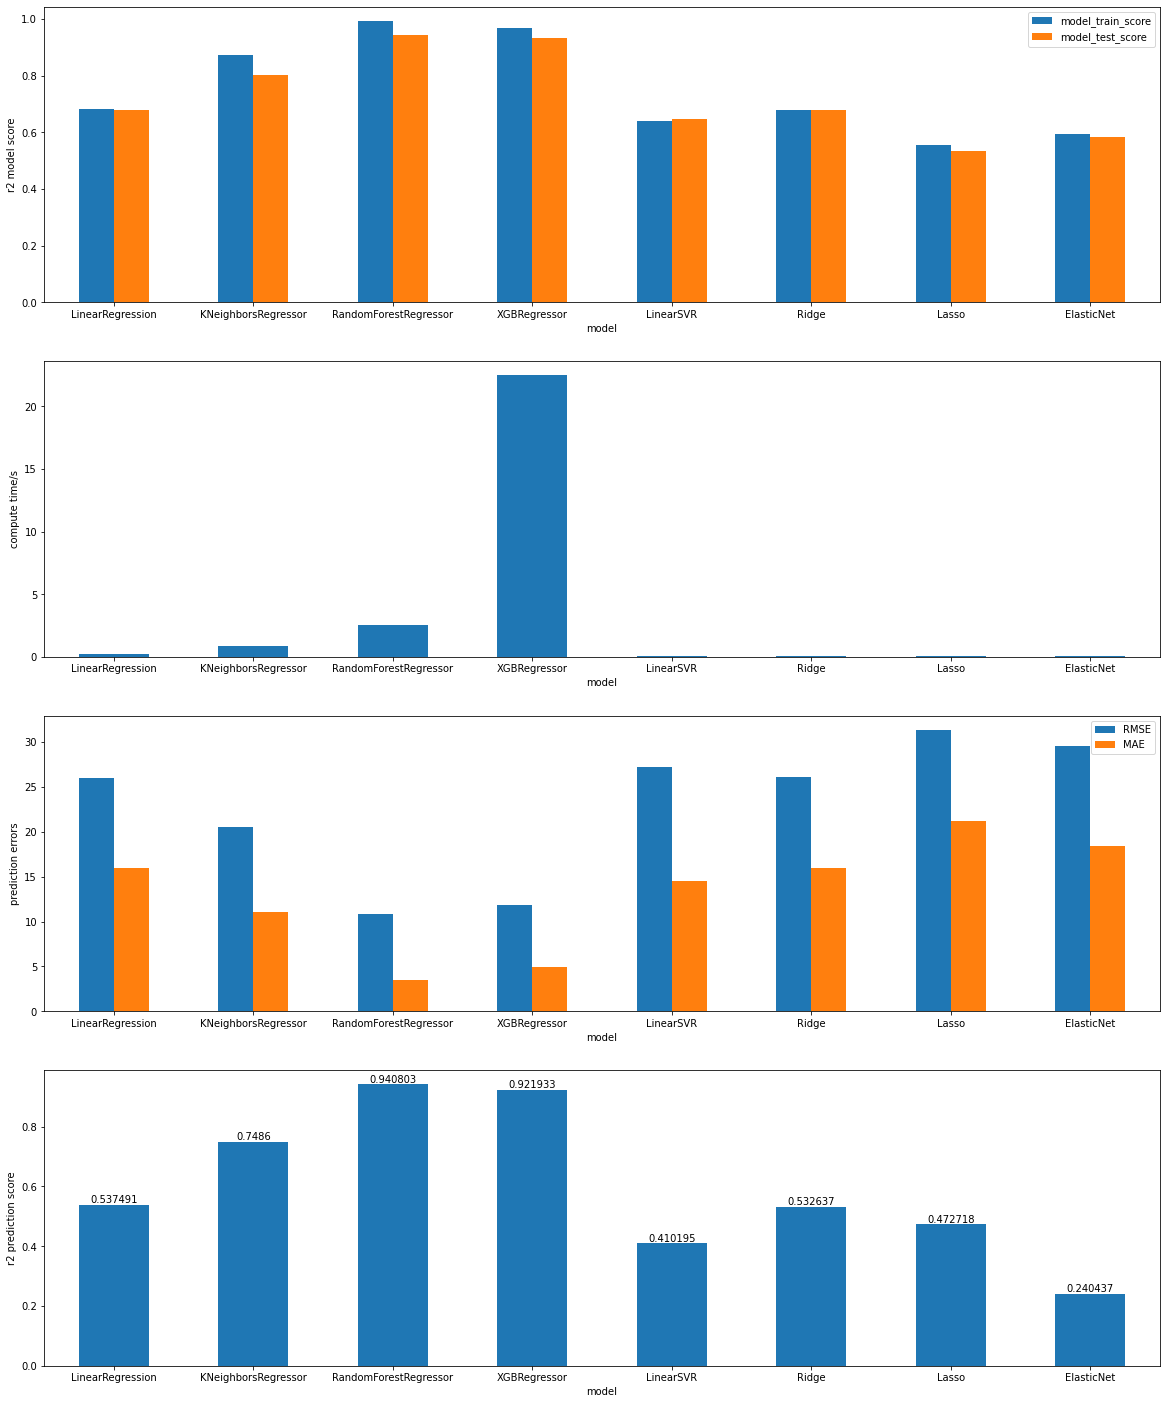

In [9]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(20, 25))

result[['model_train_score', 'model_test_score']].plot(
    rot=0, kind='bar', ylabel='r2 model score', ax=ax0)
result['compute_time'].plot(rot=0, kind='bar', ylabel='compute time/s', ax=ax1)
result[['RMSE', 'MAE']].plot(
    rot=0, kind='bar', ylabel='prediction errors',  ax=ax2)
result['R2'].plot(rot=0, kind='bar', ylabel='r2 prediction score',  ax=ax3)
for r in ax3.containers:
    ax3.bar_label(r)


## Model Choice

As we can see, with default hyper parameters, the most interesting model is RFR, because it's the one with the best ratio score / error / compute time.

In the next section we run this model with several hyper parameters and cv.

In [ ]:
parameters_rf = {
    "preprocessor__num__imputer__strategy" : ["mean"],
    'regressor__n_estimators': [100, 300, 500],
    'regressor__min_samples_leaf': [1, 3, 5],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],

    'regressor__max_depth' : [5, 15, 25, 50],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__bootstrap' : [True, False],
}

mod = ModelCompute(RandomForestRegressor(n_jobs=os.cpu_count()), parameters_rf)

print(f'computing model {type(mod.model).__name__}...', end='')
ret = runModel(mod.model, mod.params)
print('done.')




In [88]:
ret

{'model': 'RandomForestRegressor',
 'compute_time': 687.986362,
 'best_params': {'preprocessor__num__imputer__strategy': 'mean',
  'regressor__bootstrap': True,
  'regressor__max_depth': 25,
  'regressor__max_features': 'auto',
  'regressor__min_samples_leaf': 1,
  'regressor__min_samples_split': 2,
  'regressor__n_estimators': 300},
 'RMSE': 10.647691147116912,
 'MAE': 3.353491635476628,
 'R2': 0.9427525805132912,
 'cv_results': {'mean_fit_time': array([ 0.8864387 ,  2.97533622,  5.16813216,  1.07759633,  3.10136018,
          5.32388048,  1.3864202 ,  3.2373796 ,  5.25524693,  1.25227003,
          3.16944399,  4.83661938,  1.34200954,  3.37134628,  4.99118862,
          1.29530549,  2.98556356,  4.5973732 ,  1.41534963,  3.11807876,
          4.77236567,  1.22498155,  2.99220481,  4.73529067,  1.34081903,
          2.93267517,  4.33717022,  0.74416819,  1.4437396 ,  1.56524138,
          0.66855421,  0.7578866 ,  1.37581706,  0.58251638,  0.79886765,
          1.57374382,  0.4167181

## Predictions

In [14]:

from sklearn.ensemble import RandomForestRegressor

def predict_best_model(X_predict, _X_train=X_train, _y_train=y_train):   

    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    numeric_transformer = Pipeline(
        steps = [
                ("imputer", SimpleImputer(strategy='mean')),
                ("scaler", StandardScaler(with_mean=False))
            ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, selector(dtype_exclude="object")),
            ("cat", categorical_transformer, selector(dtype_include="object"))
        ]
    )

    regressor = RandomForestRegressor(
        n_jobs=os.cpu_count(),
        bootstrap=True,
        max_depth=25,
        max_features='auto',
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=300
        )

    reg = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", regressor)
         ]
    )

    reg.fit(_X_train, _y_train)
    return reg.predict(X_predict)

### Strike Visualization

-0.07601157847694631


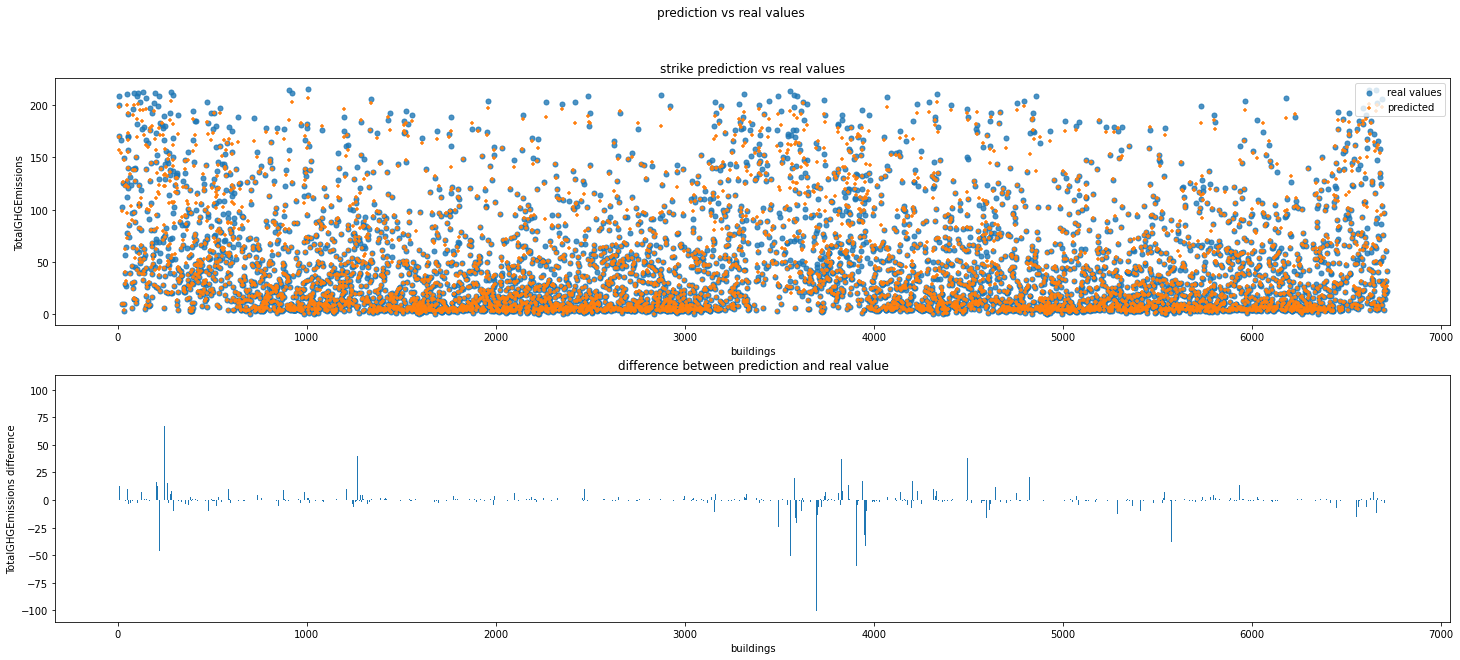

In [53]:
def show_strikes(_X, _y_real = y.values, show_graph=True):
    y_pred = predict_best_model(_X)
    differences = _y_real-y_pred

    if show_graph:
        fig, ax = plt.subplots(2, 1, figsize=(25,10))
        fig.suptitle('prediction vs real values')
        ax[0].scatter(y.index, y.values, s=25, marker='o', alpha=0.8, label='real values')
        ax[0].scatter(y.index, y_pred, s=20, marker='+', label='predicted')
        ax[0].set_xlabel('buildings')
        ax[0].set_ylabel('TotalGHGEmissions')
        ax[0].legend()
        ax[0].set_title('strike prediction vs real values')

        ax[1].bar(y.index, differences)
        ax[1].set_xlabel('buildings')
        ax[1].set_ylabel('TotalGHGEmissions difference')
        ax[1].set_title('difference between prediction and real value')

    return differences

print(show_strikes(X).mean())


In [16]:
print(X.Neighborhood.unique())

byNeighborsResult = {}

for n in X.Neighborhood.unique():
    XbyNeighbor = X.groupby('Neighborhood').get_group(n)
    byNeighborsResult[n] = show_strikes(XbyNeighbor, y[XbyNeighbor.index], False)

by_neighbors = pd.DataFrame.from_dict(byNeighborsResult)
by_neighbors

['DOWNTOWN' 'NORTHEAST' 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'BALLARD'
 'GREATER DUWAMISH' 'EAST' 'CENTRAL' 'DELRIDGE' 'SOUTHEAST' 'NORTHWEST'
 'NORTH' 'SOUTHWEST' 'North' 'Delridge' 'Ballard' 'Northwest' 'Central'
 'DELRIDGE NEIGHBORHOODS']


,DOWNTOWN,NORTHEAST,MAGNOLIA / QUEEN ANNE,LAKE UNION,BALLARD,GREATER DUWAMISH,EAST,CENTRAL,DELRIDGE,SOUTHEAST,NORTHWEST,NORTH,SOUTHWEST,North,Delridge,Ballard,Northwest,Central,DELRIDGE NEIGHBORHOODS
6,14.069300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,22.318800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12.069067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,14.334100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,2.6052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.780867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.664767
6712,-0.764200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6714,NaN,NaN,NaN,NaN,NaN,-5.1016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


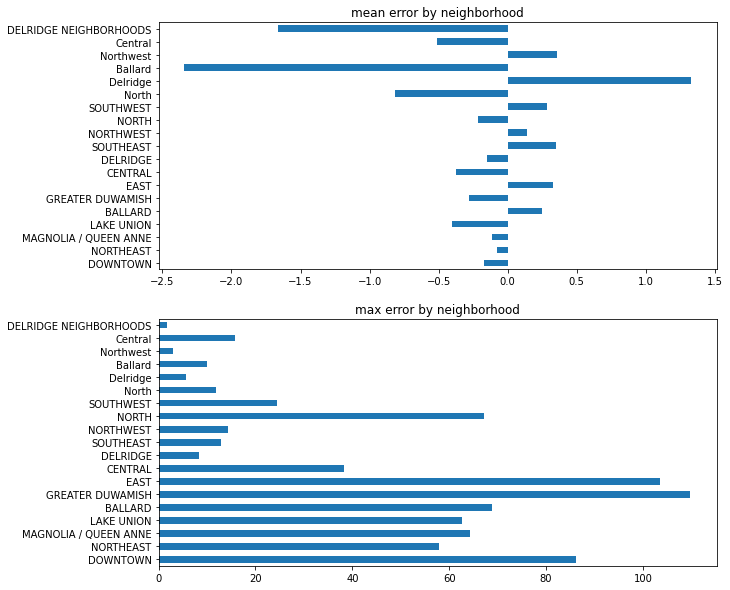

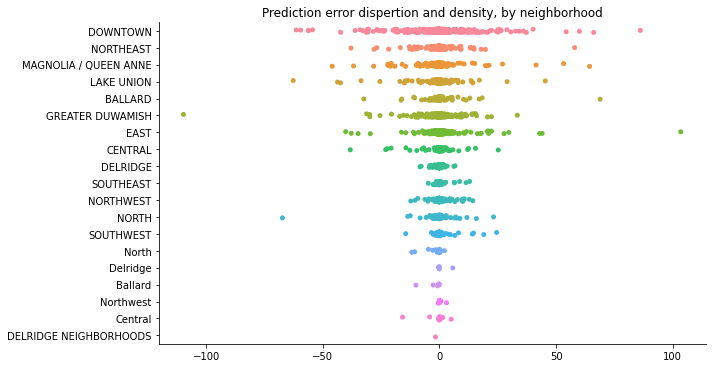

In [98]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

by_neighbors.mean().plot(kind='barh', title='mean error by neighborhood', ax=ax[0])
by_neighbors.abs().max().plot(kind='barh', title='max error by neighborhood', ax=ax[1])
sns.catplot(data=by_neighbors, height = 5, aspect=2, orient='h').set(title='Prediction error dispertion and density, by neighborhood')

We can see our model: 
* tends to lower the reality
* is very efficient for some neighborhoods : delridge, central, northwest, ballard, north

In [93]:
#  TODO wip montrer les prédiction par range de GHGEmissions

c = pd.cut(
    y,
    3,
    labels=['low', 'mid', 'high']
    )

indexes_low = c.to_frame().groupby('TotalGHGEmissions').get_group('low').index.values
X_low = X.loc[indexes_low]
y_low = y.loc[indexes_low]
y_low.to_frame()

# y.to_frame()


,TotalGHGEmissions
25,9.68
31,10.27
34,3.71
36,28.78
39,56.97
...,...
6708,60.81
6710,20.33
6712,32.17
6714,22.11


## Conclusion

Le modèle le plus performant est le RFR, avec un r2 proche des 95%, et une MAE faible (< 5).
La contrepartie est qu'il fait partie des modèles les plus long à entrainer, et de loin.

Un bon compromis score / précision / temps de calcul est le KNR, en effet la MAE est de 10, ce qui reste convenable étant donné le range de valeur de la target TotalGHGEmissions

In [111]:
np.var(X_train)


NumberofFloors           3.090380e+00
PropertyGFATotal         1.167739e+09
SourceEUI(kBtu/sf)       1.979859e+03
SiteEnergyUse(kBtu)      3.238538e+12
GHGEmissionsIntensity    4.696760e-01
BuildingAge              1.111329e+03
Distance                 4.917338e+00
NaturalGasRate           7.180288e-02
dtype: float64

<AxesSubplot:>

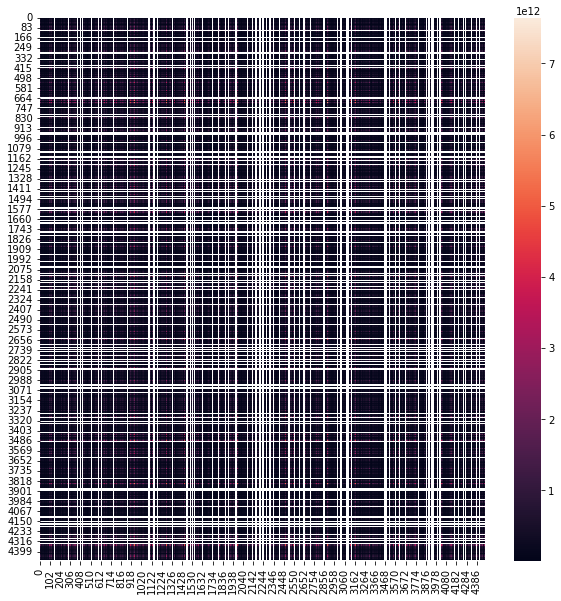

In [121]:
plt.figure(figsize=(10, 10))
sns.heatmap(np.cov(X_train[X_train.select_dtypes(exclude='object').columns]))


Reading list : 

https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94

https://en.wikipedia.org/wiki/Multicollinearity

https://en.wikipedia.org/wiki/Ordinary_least_squares

https://en.wikipedia.org/wiki/Occam%27s_razor

https://en.wikipedia.org/wiki/Minimum_description_length

https://towardsdatascience.com/features-correlations-data-leakage-confounded-features-and-other-things-that-can-make-your-deep-771bcaf84f9f

https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables

https://machinelearningmastery.com/data-leakage-machine-learning/

https://towardsdatascience.com/what-are-rmse-and-mae-e405ce230383

https://towardsdatascience.com/guide-to-encoding-categorical-features-using-scikit-learn-for-machine-learning-5048997a5c79

https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html


data leakage, à cause de la corrélation entre features, le fait de bouger un peu une feature, va non seulement influencer le resultat mais aussi les features elles memes, donc la prédiction sera plus aléatoire

scaling, normalisation, : à ne faire que sur le train set

transformation : à faire sur train et test set




**1. Avancées de l’étudiant sur son projet depuis la dernière session**

Vincent a bien avancé sur le P3; il a effectué le nettoyage de données il est sur la fin.

- Test de plusieurs modèles et benchmark

**2. Principaux sujets abordés pendant la session, obstacles à surmonter (le cas échéant), et actions nécessaires pour atteindre ces objectifs**

Balayage des modèles effectués

- Random Forrest est le meilleur
- XgBoost
- Dummy
- LinearRegression

Correlations à isoler pour éviter le leakage

Passage au log et checker l'impact

StandardScaler - MinMax

**3. Objectifs 'SMART' fixés par l'étudiant et le mentor pour la prochaine session**

- Plusieurs scores RMSE - MSE - R2
- Graphiques sur les resultats des differents modèles
- Avoir une approche iterative sur le travail sur les données
- Ajouter le temps de calcul comme choix de decision
- Analyser les résultats par topologie de bâtiments
    - Surface
    - Etages
    - Type de bâtiments
- Passage au log
- Ajouter les variables catégorielles

very important article why to normalize features:
https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94


In [ ]:
df.var().round(2)


NumberofFloors           3.120000e+00
PropertyGFATotal         1.139189e+09
ENERGYSTARScore          6.894200e+02
SourceEUI(kBtu/sf)       1.969790e+03
SiteEnergyUse(kBtu)      3.160301e+12
TotalGHGEmissions        2.304300e+03
GHGEmissionsIntensity    4.700000e-01
BuildingAge              1.106860e+03
Distance                 4.920000e+00
NaturalGasRate           7.000000e-02
dtype: float64

In [ ]:
df.skew().round(2)


NumberofFloors           0.45
PropertyGFATotal         1.61
ENERGYSTARScore         -0.90
SourceEUI(kBtu/sf)       0.97
SiteEnergyUse(kBtu)      1.60
TotalGHGEmissions        1.47
GHGEmissionsIntensity    1.47
BuildingAge              0.52
Distance                 0.80
NaturalGasRate           0.75
dtype: float64

certaines features ne suivent pas des distributions normales, mais on peut les transformer pour y parvenir: 

TODO : remove negative values (PropertyGFABuilding, for inst.)

IndexError: index 2 is out of bounds for axis 1 with size 2

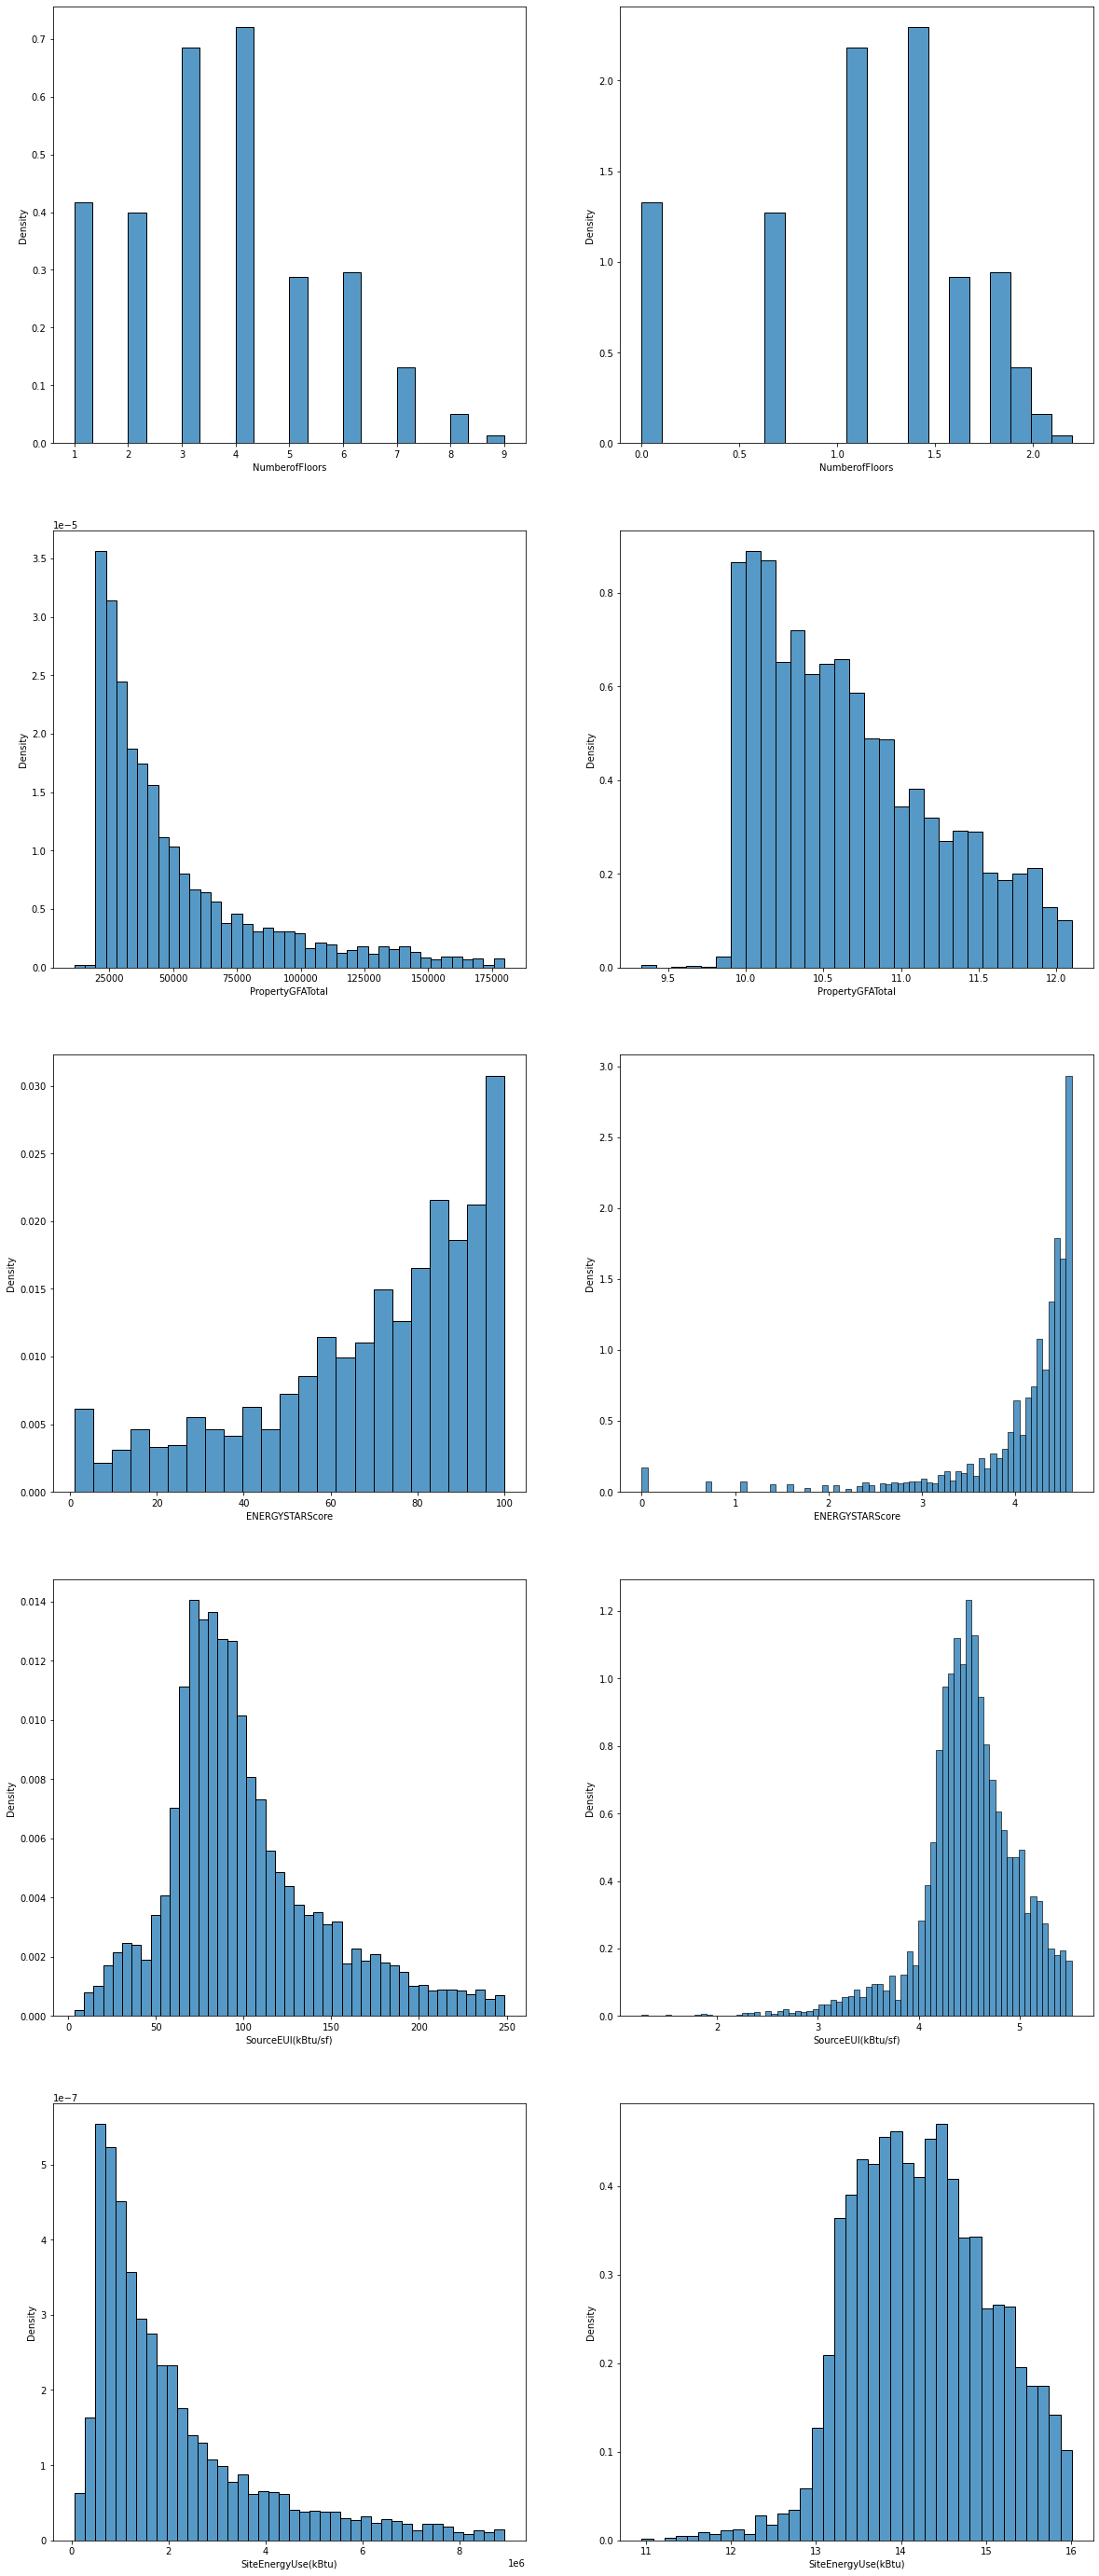

In [ ]:
from sklearn.preprocessing import FunctionTransformer
# on regarde le resultat du passage au log pour certaines features, si cela permet d'avoir une distribution normale
# TODO WIP

to_log_features = df.select_dtypes(['float', 'int']).columns
size = to_log_features.shape[0]

nrows = int(size/2)
ncols = int(size/4)
fig, ax = plt.subplots(nrows, ncols, sharex=False,
                       sharey=False, figsize=(20, 50))

for i, col in enumerate(to_log_features):
    logtransformer = FunctionTransformer(
        np.log, inverse_func=np.exp, check_inverse=True)
    y_log = logtransformer.transform(df[col])

    # print(f'ploting first on ({i%nrows},{ i//nrows * 2}), second on ({i%nrows},{1 + i//nrows * 2})')

    sns.histplot(data=df[col], stat="density", ax=ax[i %
                 nrows, i//nrows * 2])  # .set_title(col)
    # ax[0].set_title("Without log")

    # .set_title(f'{col}-log')
    sns.histplot(data=y_log, stat="density",
                 ax=ax[i % nrows, 1 + i//nrows * 2])
    # ax[1].set_title("With log")

plt.show()
